In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopandas as gpd
from shapely.geometry import Point
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cf

from metricas_rendimiento import KGE, KGEmod, ECDF
from funciones import caudal_anuario_aforos

In [2]:
start = '1991-10-01'
end = '2020-09-30'

## Capas
### Cuencas

In [3]:
# cargar polígono de las demarcaciones hidrográficas
cuencas = gpd.read_file('../data/carto/hidrografia/demarcaciones.shp')
cuencas[['CUENCA_ID', 'COD_DEMAR']] = cuencas[['CUENCA_ID', 'COD_DEMAR']].astype(int)
cuencas.set_index('CUENCA_ID', drop=True, inplace=True)
cuencas = cuencas[~cuencas.COD_DEMAR.isin([101, 61, 111, 121, 122, 123, 124, 125, 126, 127, 150, 63, 64, 160])]
cuencas['pais'] = 'ES'

# disolver el polígono
area = cuencas.dissolve(by='pais')

### Puntos
#### EFASv5

In [26]:
# cargar puntos de reporte de EFASv5
efas = gpd.read_file('../data/EFASv5/reporting_points/reporting_points_performance_indroea.shp')
efas.set_index('ObsID', drop=False, inplace=True)
# efas.set_index('ObsID', drop=True, inplace=True)
efas['EC_calib'] = efas['EC_calib'].astype(int)
for col in ['StationLon', 'StationLat', 'LisfloodX', 'LisfloodY']:
    efas[col] = efas[col].astype(float)
efas = efas[efas['Country co'] == 'ES']
# mantener sólo puntos calibrados
efas = efas[efas.EC_calib >= 1]
# recortar a las cuencas de estudio
efas = gpd.clip(efas, area.geometry)

#### Anuario de aforos

In [5]:
# cargar estaciones del anuario de aforos
anuario = gpd.read_file('../data/anuario_aforos/GIS/estaciones.shp')
anuario.set_index('indroea', drop=True, inplace=True)

#### Comparativa

El Anuario de Aforos tiene 1476 estaciones
EFASv5 tiene 226 puntos


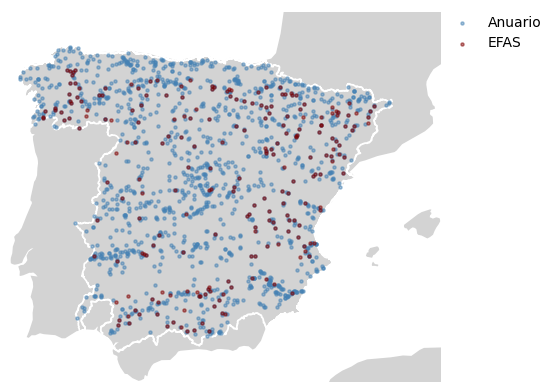

In [6]:
print(f'El Anuario de Aforos tiene {anuario.shape[0]} estaciones')
print(f'EFASv5 tiene {efas.shape[0]} puntos')

# plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
area.plot(ax=ax, facecolor='none', edgecolor='w', linewidth=1.2);
ax.scatter(anuario.geometry.x, anuario.geometry.y, c='steelblue', s=5, alpha=.5, label='Anuario')
ax.scatter(efas.geometry.x, efas.geometry.y, c='maroon', s=5, alpha=.5, label='EFAS')
ax.axis('off')
fig.legend(frameon=False, bbox_to_anchor=[.8, .6, .225, .3]);

#### ID ROEA de los puntos EFAS

In [27]:
if ('indroea' not in efas.columns) & (efas.index.name != 'indroea'):

    # convertir en coordenadas projectadas para poder calcular distancias
    efas = efas.to_crs(25830)
    anuario = anuario.to_crs(25830)
    
    # se toma el ID del punto más cercano (mínimo 10000 m)
    dist_max = 1e4
    efas['indroea'] = np.nan
    for id in tqdm(efas.index):
        x, y = efas.loc[[id]].geometry.x, efas.loc[[id]].geometry.y
        dist = anuario.distance(Point(x, y))
        dist = dist[dist < dist_max]
        if dist.shape[0] > 0:
            efas.loc[id, 'indroea'] = dist.idxmin()
    
    # definir sistema de coordenadas
    efas = efas.to_crs(4326)
    
    # ubicar los puntos en sus coordenadas en LISFLOOD
    geometry = [Point(lon, lat) for lon, lat in zip(efas.LisfloodX, efas.LisfloodY)]
    efas = gpd.GeoDataFrame(efas, geometry=geometry)

    # exportar
    efas.to_file('../data/EFASv5/reporting_points/reporting_points_performance_indroea.shp')
    print('EXPORTAR')
# else:

#     # importar capa corregida
#     efas = gpd.read_file('../data/EFASv5/reporting_points/reporting_points_performance_indroea.shp')
#     if ('ObsID' not in efas.columns) & (efas.index.name == 'ObsID'):
#         efas['ObsID'] = efas.index
#     efas.set_index('indroea', drop=True, inplace=True)

In [28]:
print(f'EFASv5 tiene {efas.shape[0]} puntos')

EFASv5 tiene 225 puntos


## Caudal

### Observado

In [29]:
path_AA = 'C:/Users/jcr693/Documents/anuario_aforos/'

In [30]:
# cargar series completas de caudal
cuencas = [dir for dir in os.listdir(path_AA) if os.path.isdir(os.path.join(path_AA, dir))]
Qobs = pd.DataFrame(index=pd.date_range(start, end, freq='1d'), dtype=float)
for cuenca in tqdm(cuencas):
    Q = caudal_anuario_aforos(f'{path_AA}{cuenca}/afliq.csv', start=start, end=end)
    Qobs = pd.concat((Qobs, Q), axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
print(f'nº de estaciones en las series de caudal:\t{Qobs.shape[1]}')
print(f'nº de estaciones en la tabla de atributos:\t{anuario.shape[0]}')

nº de estaciones en las series de caudal:	1072
nº de estaciones en la tabla de atributos:	1476


In [32]:
# extraer series de caudal observado para los puntos EFAS con ID del Anuario de Aforos
ids = Qobs.columns.intersection(efas.index)
Qobs = Qobs[ids]

print(f'nº de puntos EFAS en las series de caudal:\t{Qobs.shape[1]}')

nº de puntos EFAS en las series de caudal:	22


### Simulado

In [33]:
# cargar caudal reanálisis
Qsim = xr.open_mfdataset('../data/EFASv5/caudal/reporting_points/dis_*.nc', chunks='auto')['discharge']

# eliminar días duplicados
Qsim = Qsim.drop_duplicates('time', keep='last')

# mantener sólo las estaciones de EFAS con caudal observado
id = efas.loc[Qobs.columns, 'ObsID'].to_list()
Qsim = Qsim.sel(id=id, time=slice(start, end)).compute()

# convertir en pd.DataFrame
Qsim = Qsim.to_pandas()

# renombrar las columnas con su indroea
Qsim.rename(columns={efas_id: indroea for indroea, efas_id in zip(efas.index, efas.ObsID)}, inplace=True)

Qsim.head()

id,1175,1186,1262,1265,1285,1292,3001,3002,3003,3004,...,3014,3015,3018,3026,3030,3031,3034,3041,3045,3046
time,,,,,,,,,,,,,,,,,,,,,
1991-10-01,21.245579,49.317866,18.297151,5.742411,25.605246,8.516427,4.086212,7.102718,77.281630,9.739563,...,11.284474,4.461415,23.587006,0.253643,5.896191,2.681926,7.013578,3.627028,0.106124,1.409754
1991-10-02,16.453779,38.576202,14.949585,4.462829,20.843347,4.951757,4.069131,7.088454,77.248353,9.465565,...,11.227326,4.524107,22.437117,0.231432,4.963141,1.086412,6.977654,2.217532,0.072654,0.647154
1991-10-03,12.719513,30.859718,12.130424,3.680133,17.130129,2.749160,4.054533,7.070829,77.224959,9.333138,...,11.124664,4.561050,21.364154,0.225337,4.451331,0.712945,6.960077,1.184537,0.056506,0.402250
1991-10-04,9.706337,25.262831,9.816425,3.083078,14.165002,2.137763,4.060422,7.067398,77.212037,9.237372,...,10.315820,4.578596,20.631632,0.223576,4.205645,0.569222,6.966355,0.539046,0.052658,0.379038
1991-10-05,7.243885,21.915620,7.899102,2.607173,11.832344,2.119324,4.061461,7.054434,77.211373,10.522376,...,8.072449,4.588314,20.101208,0.222735,4.109909,0.503954,6.976666,0.317289,0.054232,0.386283


## Rendimiento EFASv5

In [44]:
# calcular el coeficiente de eficiencia modificado de Kling-Gupta y sus componentes
rend= pd.DataFrame({id: KGEmod(Qobs[id], Qsim[id]) for id in Qobs.columns.intersection(Qsim.columns)},
                   index=['KGEmod', 'alpha', 'beta', 'r']).transpose()

In [45]:
efas = pd.concat((efas, rend), axis=1)

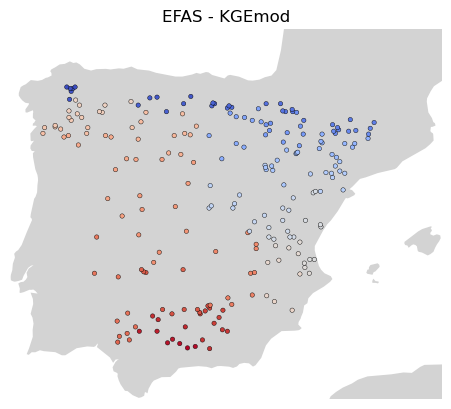

In [49]:
# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
efas.plot(c=efas.KGEmod, cmap='coolwarm_r', edgecolor='k', lw=.3, markersize=10, ax=ax)
ax.set_title('EFAS - KGEmod')
ax.axis('off');

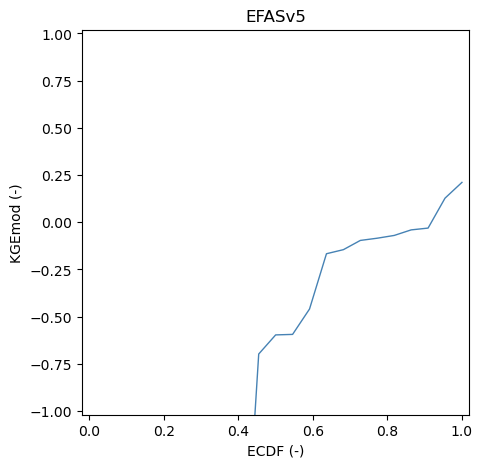

In [50]:
ecdf_KGE = ECDF(efas.KGEmod, plot=True, title='EFASv5', ylabel='KGEmod (-)')